# Data Preparation

In [ ]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import seaborn as sns
import pandas as pd

# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_file = 'convo_fraud.keras'

Keras = 3.8.0
Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the Dataset

In [ ]:
import os
import pandas as pd

# Define the directory for saving the combined dataset
base_dir = "/content/drive/My Drive/SIT_Capstone/"
csv_file = os.path.join(base_dir, "combined_convo_dataset.csv")

# Define the paths for your datasets
splits = {
    'train': 'hf://datasets/BothBosu/scam-dialogue/scam-dialogue_train.csv',
    'test': 'hf://datasets/BothBosu/scam-dialogue/scam-dialogue_test.csv',
    'multi_agent_train': 'hf://datasets/BothBosu/multi-agent-scam-conversation/agent_conversation_train.csv',
    'multi_agent_test': 'hf://datasets/BothBosu/multi-agent-scam-conversation/agent_conversation_test.csv',
    'single_agent_train': 'hf://datasets/BothBosu/single-agent-scam-conversations/single-agent-scam-dialogue_train.csv',
    'single_agent_test': 'hf://datasets/BothBosu/single-agent-scam-conversations/single-agent-scam-dialogue_test.csv'
}
gen_convo_path = "hf://datasets/BothBosu/Scammer-Conversation/gen_conver_noIdentifier_1000.csv"

# Load datasets
try:
    train_df = pd.read_csv(splits['train'])
    test_df = pd.read_csv(splits['test'])
    multi_agent_train_df = pd.read_csv(splits['multi_agent_train'])
    multi_agent_test_df = pd.read_csv(splits['multi_agent_test'])
    single_agent_train_df = pd.read_csv(splits['single_agent_train'])
    single_agent_test_df = pd.read_csv(splits['single_agent_test'])
    gen_convo_df = pd.read_csv(gen_convo_path)

    # Standardize column naming
    for df in [train_df, test_df, multi_agent_train_df, multi_agent_test_df, single_agent_train_df, single_agent_test_df, gen_convo_df]:
        # Rename 'dialogue' or 'conversation' to 'conversation'
        if 'dialogue' in df.columns:
            df.rename(columns={'dialogue': 'conversation'}, inplace=True)
        elif 'conversation' not in df.columns:
            raise ValueError("Missing both 'dialogue' and 'conversation' columns in one of the datasets.")

        # Rename 'labels' to 'label' if present
        if 'labels' in df.columns:
            df.rename(columns={'labels': 'label'}, inplace=True)

    # Combine datasets into one
    combined_df = pd.concat([train_df, test_df, multi_agent_train_df, multi_agent_test_df, single_agent_train_df, single_agent_test_df, gen_convo_df], ignore_index=True)

    # Save the combined dataset
    combined_df.to_csv(csv_file, index=False)
    print("Combined dataset saved successfully!")

    # Print details
    print("First 5 rows of the combined dataset:")
    print(combined_df.head())

    # Total count of rows in the combined dataset
    total_count = len(combined_df)
    print(f"\nTotal number of rows in the combined dataset: {total_count}")

    # Count of each label
    if 'label' in combined_df.columns:
        label_counts = combined_df['label'].value_counts()
        print("Count of each label:")
        print(label_counts)
    else:
        print("Warning: No 'label' column found in the combined dataset.")

except Exception as e:
    print(f"An error occurred: {e}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Combined dataset saved successfully!
First 5 rows of the combined dataset:
                                        conversation type  label personality
0  caller: Hello, is this John? receiver: Yes, it...  ssn      1         NaN
1  caller: Hello, is this John? receiver: Yeah, t...  ssn      1         NaN
2  caller: Hello, is this Mr. Johnson? receiver: ...  ssn      1         NaN
3  caller: Hello, is this John? receiver: Yeah, t...  ssn      1         NaN
4  caller: Hello, this is Officer Johnson from th...  ssn      1         NaN

Total number of rows in the combined dataset: 5800
Count of each label:
label
1    2924
0    2876
Name: count, dtype: int64


# Data Cleaning

In [ ]:
# Remove duplicates
combined_df = combined_df.drop_duplicates()
print(f"Total rows after removing duplicates: {len(combined_df)}")

# Print new label_counts
label_counts = combined_df['label'].value_counts()
print(label_counts)

Total rows after removing duplicates: 5556
label
0    2839
1    2717
Name: count, dtype: int64


# Ratio of Normal to Fraud data Distribution

Ratio of normal to fraud: 0.91
Normal label percentage: 47.60%
Fraud label percentage: 52.40%


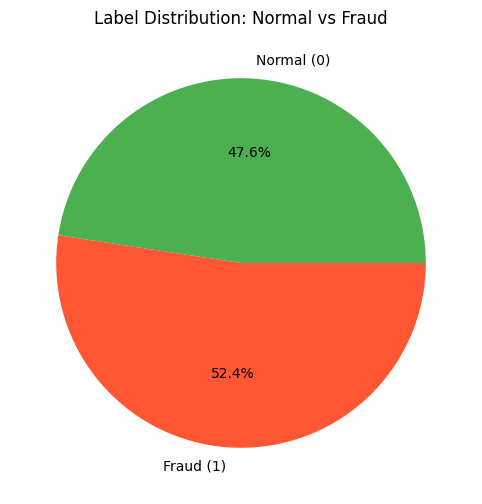

In [ ]:
# Count the occurrences of each label dynamically
label_counts = df['label'].value_counts().to_dict()

# Total number of entries
total_count = sum(label_counts.values())

# Extract counts for fraud (1) and normal (0) labels
normal_count = label_counts.get(0, 0)
fraud_count = label_counts.get(1, 0)

# Calculate the ratio of normal to fraud
if fraud_count > 0:  # Avoid division by zero
    ratio = normal_count / fraud_count
else:
    ratio = float('inf')  # If no fraud cases, set ratio to infinity

# Print the ratio and percentages
print(f"Ratio of normal to fraud: {ratio:.2f}")
print(f"Normal label percentage: {(normal_count / total_count) * 100:.2f}%")
print(f"Fraud label percentage: {(fraud_count / total_count) * 100:.2f}%")

# Visualize the label distribution as a pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    [normal_count, fraud_count],
    labels=['Normal (0)', 'Fraud (1)'],
    autopct='%1.1f%%',
    colors=['#4CAF50', '#FF5733']
)
plt.title('Label Distribution: Normal vs Fraud')
plt.show()

# Model Building

In [ ]:
pip install transformers datasets torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPTNeoForSequenceClassification, AdamW, get_scheduler
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Initialize the GPT-Neo tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
tokenizer.pad_token = tokenizer.eos_token  # Add padding token for GPT models

# Select only the required columns
X = combined_df['conversation']  # Features
y = combined_df['label']         # Target

# Split the dataset into training and testing sets with an 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data
def tokenize_texts(texts, tokenizer, max_length=256):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

print("Tokenizing training data...")
train_encodings = tokenize_texts(X_train, tokenizer)
print("Tokenizing testing data...")
test_encodings = tokenize_texts(X_test, tokenizer)

# Convert labels to torch tensors for binary classification
train_labels = torch.tensor(y_train.values, dtype=torch.long)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Print dataset statistics
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
avg_length = X.apply(lambda x: len(x.split())).mean()
print(f"Average text length: {avg_length}")
print(f"Training label distribution:\n{y_train.value_counts()}")
print(f"Testing label distribution:\n{y_test.value_counts()}")

# Convert tokenized inputs into TensorDataset
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_labels
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    test_labels
)

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Tokenizing training data...
Tokenizing testing data...
Training set size: 4444
Testing set size: 1112
Average text length: 316.81011519078476
Training label distribution:
label
0    2295
1    2149
Name: count, dtype: int64
Testing label distribution:
label
1    568
0    544
Name: count, dtype: int64


In [ ]:
# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load GPT-Neo model for binary classification
model = GPTNeoForSequenceClassification.from_pretrained(
    "EleutherAI/gpt-neo-125M",
    num_labels=2  # Binary classification
)
model.config.pad_token_id = tokenizer.eos_token_id
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training configurations
epochs = 10
num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)

# Define learning rate scheduler
scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Training and validation loop
history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}
best_val_loss = float("inf")
early_stopping_patience = 3
no_improvement_epochs = 0
model_checkpoint_path = "best_gpt_neo_model.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch in tqdm(train_loader, desc="Training"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        train_loss += loss.item()
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validation"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            val_loss += outputs.loss.item()
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_total
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping and checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
        torch.save(model.state_dict(), model_checkpoint_path)
        print("Model checkpoint saved.")
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= early_stopping_patience:
        print("Early stopping triggered.")
        break

# Load the best model before evaluation
model.load_state_dict(torch.load(model_checkpoint_path))
print("Training complete. Best model loaded.")

# Display training history
print("\nTraining History:")
print(history)

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/10


Training: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Train Loss: 0.5800, Train Accuracy: 0.7313


Validation: 100%|██████████| 70/70 [00:18<00:00,  3.85it/s]


Validation Loss: 0.1928, Validation Accuracy: 0.9317
Model checkpoint saved.

Epoch 2/10


Training: 100%|██████████| 278/278 [03:29<00:00,  1.33it/s]


Train Loss: 0.0692, Train Accuracy: 0.9806


Validation: 100%|██████████| 70/70 [00:18<00:00,  3.85it/s]


Validation Loss: 0.0186, Validation Accuracy: 0.9973
Model checkpoint saved.

Epoch 3/10


Training: 100%|██████████| 278/278 [03:29<00:00,  1.33it/s]


Train Loss: 0.0077, Train Accuracy: 0.9993


Validation: 100%|██████████| 70/70 [00:18<00:00,  3.87it/s]


Validation Loss: 0.0071, Validation Accuracy: 0.9991
Model checkpoint saved.

Epoch 4/10


Training: 100%|██████████| 278/278 [03:29<00:00,  1.33it/s]


Train Loss: 0.0025, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:18<00:00,  3.87it/s]


Validation Loss: 0.0045, Validation Accuracy: 0.9991
Model checkpoint saved.

Epoch 5/10


Training: 100%|██████████| 278/278 [03:29<00:00,  1.33it/s]


Train Loss: 0.0013, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:18<00:00,  3.87it/s]


Validation Loss: 0.0031, Validation Accuracy: 0.9991
Model checkpoint saved.

Epoch 6/10


Training: 100%|██████████| 278/278 [03:29<00:00,  1.33it/s]


Train Loss: 0.0008, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:18<00:00,  3.86it/s]


Validation Loss: 0.0026, Validation Accuracy: 0.9991
Model checkpoint saved.

Epoch 7/10


Training: 100%|██████████| 278/278 [03:29<00:00,  1.33it/s]


Train Loss: 0.0006, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:18<00:00,  3.87it/s]


Validation Loss: 0.0022, Validation Accuracy: 0.9991
Model checkpoint saved.

Epoch 8/10


Training: 100%|██████████| 278/278 [03:29<00:00,  1.33it/s]


Train Loss: 0.0005, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:18<00:00,  3.88it/s]


Validation Loss: 0.0020, Validation Accuracy: 0.9991
Model checkpoint saved.

Epoch 9/10


Training: 100%|██████████| 278/278 [03:29<00:00,  1.33it/s]


Train Loss: 0.0004, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:18<00:00,  3.87it/s]


Validation Loss: 0.0018, Validation Accuracy: 0.9991
Model checkpoint saved.

Epoch 10/10


Training: 100%|██████████| 278/278 [03:29<00:00,  1.33it/s]


Train Loss: 0.0004, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:18<00:00,  3.87it/s]


Validation Loss: 0.0018, Validation Accuracy: 0.9991
Model checkpoint saved.


<ipython-input-8-7f91250cfe01>:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_checkpoint_path))


Training complete. Best model loaded.

Training History:
{'train_loss': [0.5799618429310031, 0.06923949621322988, 0.0077305750948797386, 0.0024550997335635455, 0.0012936934403926068, 0.0008308814252840218, 0.0006123307401977276, 0.0004878084397702662, 0.000420122477806989, 0.0003894418084508406], 'val_loss': [0.19277391268738678, 0.018595475001659777, 0.007124304090809476, 0.004470227133632372, 0.0030764035562502352, 0.002622270704679457, 0.002164489638900185, 0.0019700214170110743, 0.0018400894117283834, 0.0018117301240896007], 'train_accuracy': [0.7313231323132313, 0.9806480648064807, 0.9993249324932493, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_accuracy': [0.9316546762589928, 0.9973021582733813, 0.9991007194244604, 0.9991007194244604, 0.9991007194244604, 0.9991007194244604, 0.9991007194244604, 0.9991007194244604, 0.9991007194244604, 0.9991007194244604]}


# Model Architecture

In [ ]:
print(model)

GPTNeoForSequenceClassification(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj)

# Plotting the Learning Curve of the Model

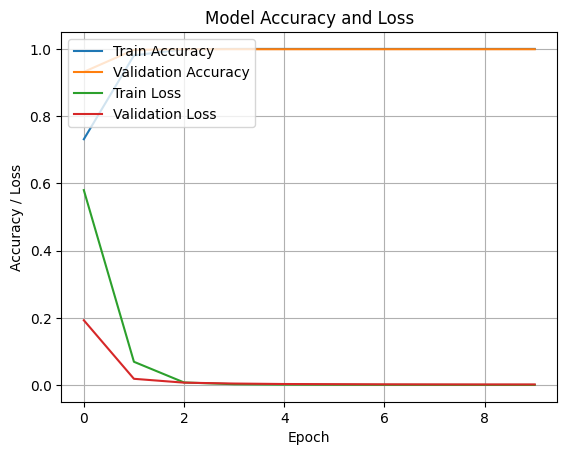

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')

# Plot Loss
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')

# Add title and labels
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy / Loss')
plt.xlabel('Epoch')

# Add legend
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)  # Optional for better readability
plt.show()

# Precision, Recall, F1-Score


In [ ]:
from sklearn.metrics import classification_report

# Ensure model is in evaluation mode
model.eval()

# Prepare the test data
test_encodings = tokenize_texts(X_test, tokenizer)
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(y_test.values, dtype=torch.float32)  # Make sure labels are tensors
)

# DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# No gradients needed for inference
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)  # Adjust for binary classification

        # Convert logits to probabilities
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()  # Convert probabilities to binary labels

        # Modify how predictions are extracted from the logits
        preds = torch.argmax(probs, dim=-1)  # Get the class with the highest probability

        # Store true labels and predictions
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())

# Generate classification report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       544
         1.0       1.00      1.00      1.00       568

    accuracy                           1.00      1112
   macro avg       1.00      1.00      1.00      1112
weighted avg       1.00      1.00      1.00      1112



# Confusion Matrix

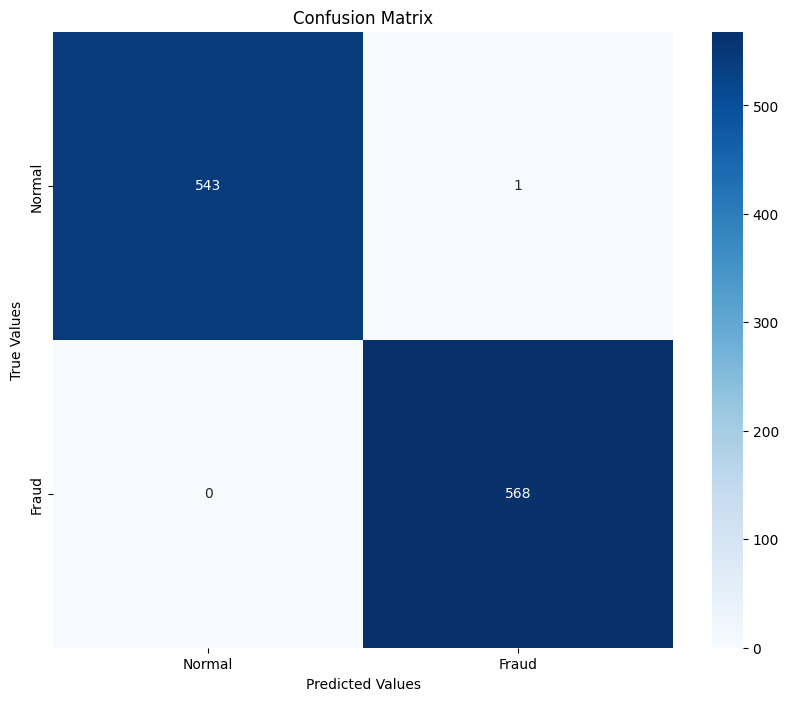

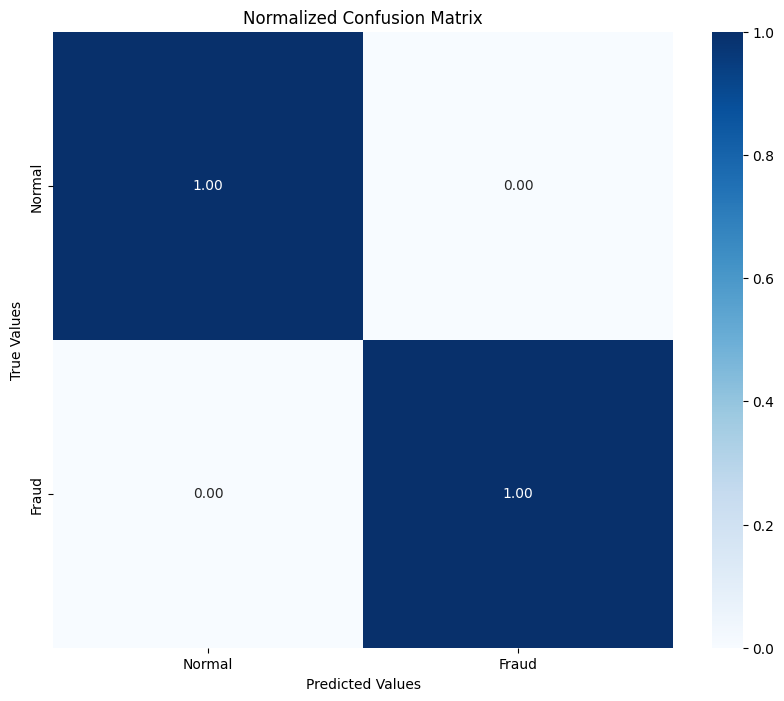

DSC: 0.9991002646613573, Sensitivity: 0.9990808823529411, Specificity: 0.9990808823529411, Accuracy: 0.9991007194244604


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import torch

def calculate_metrics(y_true, y_pred, classes=['Normal', 'Fraud']):
    """
    Calculate and display various evaluation metrics based on true and predicted labels.

    Parameters:
    - y_true: Array of true labels.
    - y_pred: Array of predicted labels.
    - classes: List of class labels (default: ['Normal', 'Fraud']).

    Returns:
    - dsc: Dice similarity coefficient (mean across classes).
    - sensitivity: Mean sensitivity across classes.
    - specificity: Mean specificity across classes.
    - accuracy: Overall accuracy.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Confusion Matrix')
    plt.show()

    # Normalize the confusion matrix by row (true labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate the Dice similarity coefficient (DSC) for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])

    # Calculate the sensitivity (recall) for each class and average them
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])

    # Calculate the specificity for each class and average them
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Calculate the overall accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Print the evaluation metrics
    print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

    return dsc, sensitivity, specificity, accuracy

# Make sure model is in evaluation mode
model.eval()

# Prepare the test data (tokenized input data for PyTorch)
test_encodings = tokenize_texts(X_test, tokenizer)
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(y_test.values, dtype=torch.float32)  # Ensure labels are tensors
)

# DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# No gradients needed for inference
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)

        # Get the predicted probabilities
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()  # Use thresholding to get the predicted labels (0 or 1)

        # Modify how predictions are extracted from the logits
        preds = torch.argmax(probs, dim=-1)  # Get the class with the highest probability

        # Append true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())  # Move labels back to CPU for numpy operations
        predictions.extend(preds.cpu().numpy())   # Move predictions back to CPU for numpy operations

# Calculate metrics
dsc, sensitivity, specificity, accuracy = calculate_metrics(true_labels, predictions)

In [ ]:
!pip install transformers torch gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import torch
from transformers import GPT2Tokenizer, GPTNeoForSequenceClassification
import gradio as gr

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load tokenizer and model from Hugging Face
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-125M")

# Initialize model and load the saved weights
model = GPTNeoForSequenceClassification.from_pretrained("EleutherAI/gpt-neo-125M", num_labels=2)
model.load_state_dict(torch.load("best_gpt_neo_model.pt"))  # Load the saved model weights
model.to(device)
model.eval()

# Function to classify caller messages
def classify_caller_message(caller_messages, scam_detected=False):
    """
    Classifies the latest caller message while considering past caller messages only.
    """
    scam_threshold = 0.7 if scam_detected else 0.5  # Increase scam threshold after a scam is found

    if not caller_messages:
        return "No caller messages to analyze.", scam_detected

    # Format conversation history (only caller messages)
    input_text = " ".join([f"Caller: {text}" for text in caller_messages])

    # # Disable padding for small inputs such as "Hello"
    # inputs = tokenizer(input_text, padding=False, truncation=True, return_tensors="pt").to(device)
    tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-125M", use_fast=True)

    # Model inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to probability (using sigmoid for binary classification)
    prediction = torch.sigmoid(outputs.logits).item()

    # Determine scam classification
    is_scam = prediction > scam_threshold
    response = "🚨 Scam Alert: This message might be a scam!" if is_scam else "✅ Caller message seems safe."

    return response, is_scam  # Return classification & scam detection flag

# Gradio Chat Interface
def chat_interface(speaker, message, conversation_log=[], caller_messages=[], scam_detected=False):
    """
    Handles the chat flow while ensuring only the caller's messages affect scam classification.
    """
    conversation_log.append((speaker, message))  # Append to full log

    if speaker == "caller":
        caller_messages.append(message)  # Only keep caller messages for classification
        response, scam_detected = classify_caller_message(caller_messages, scam_detected)
        conversation_log.append(("System", response))
    else:
        response = "✅ Receiver message recorded (ignored for scam detection)."  # Receiver messages do not affect model
        conversation_log.append(("System", response))

    return conversation_log, caller_messages, scam_detected, ""  # Updated states & reset input

# Create Gradio UI
with gr.Blocks() as demo:
    chatbot = gr.Chatbot(label="Conversation Log")
    speaker = gr.Dropdown(["caller", "receiver"], label="Speaker")
    msg = gr.Textbox(placeholder="Enter message...")
    clear = gr.Button("Clear Chat")

    # Maintain separate states
    caller_messages = gr.State([])  # Stores only caller messages
    scam_flag = gr.State(False)  # Tracks scam detection

    msg.submit(chat_interface, [speaker, msg, chatbot, caller_messages, scam_flag],
               [chatbot, caller_messages, scam_flag, msg])

    clear.click(lambda: ([], [], False, ""), outputs=[chatbot, caller_messages, scam_flag, msg])

# Launch Gradio App
demo.launch(share=True)


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-14-bc64c0e81da1>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1dcf21032477c2a63a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
